In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import numpy as np
from src.audiopreprocessing.audio_preprocessor import AudioPreprocessor

# Data Reading
Reading in the data and preprocessing for the classification later on

In [3]:
from src.io.data_loader import AudioFileLoader

data_loader = AudioFileLoader();

data_folder = Path("../data/0")
data_loader.load_audio_files_from_folder(str(data_folder), label=0)

data_folder = Path("../data/1")
data_loader.load_audio_files_from_folder(str(data_folder), label=1)

training_data = data_loader.get_data()

X = np.array(training_data[data_loader.AUDIO_COL_NAME])
X_sample_rate = training_data[data_loader.SAMPLE_RATE_COL_NAME]
Y = training_data[data_loader.LABEL_COL_NAME]

preprocessor = AudioPreprocessor(X, X_sample_rate)
X_mfcc = preprocessor.extract_mffc_features()


# Visualizing the data
Visualize the data in various ways

In [4]:
from src.visualization.audio_visualization import AudioVisualizer

visualizer = AudioVisualizer(X, X_sample_rate)
audio_index = 10

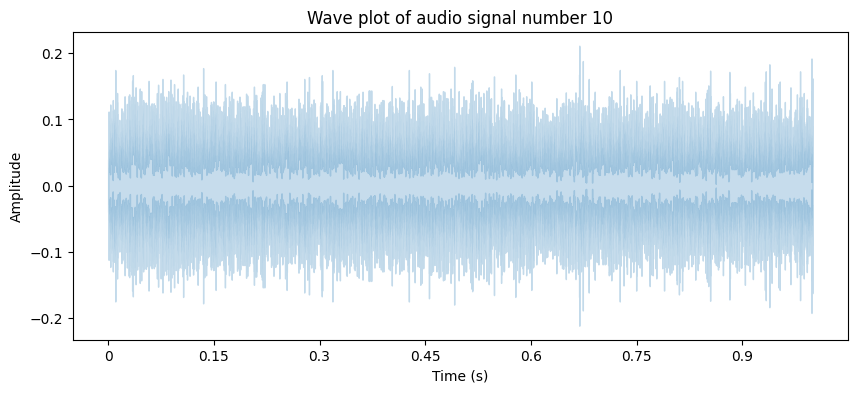

In [5]:
visualizer.create_wav_plot(audio_signal_index=audio_index)

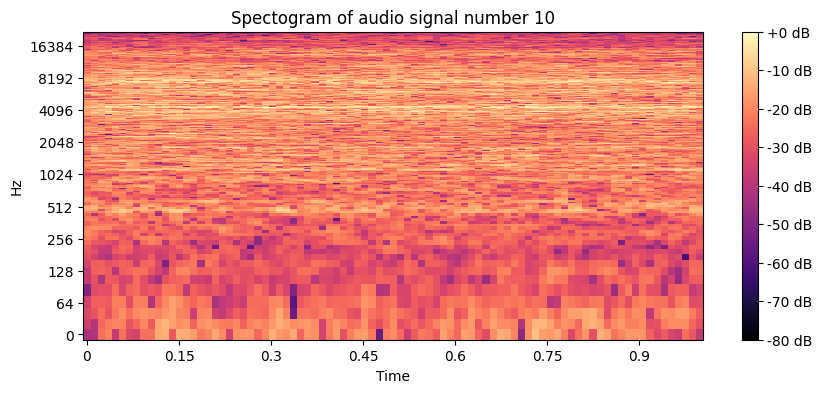

In [8]:
visualizer.create_spectrogram_plot(audio_signal_index=audio_index)

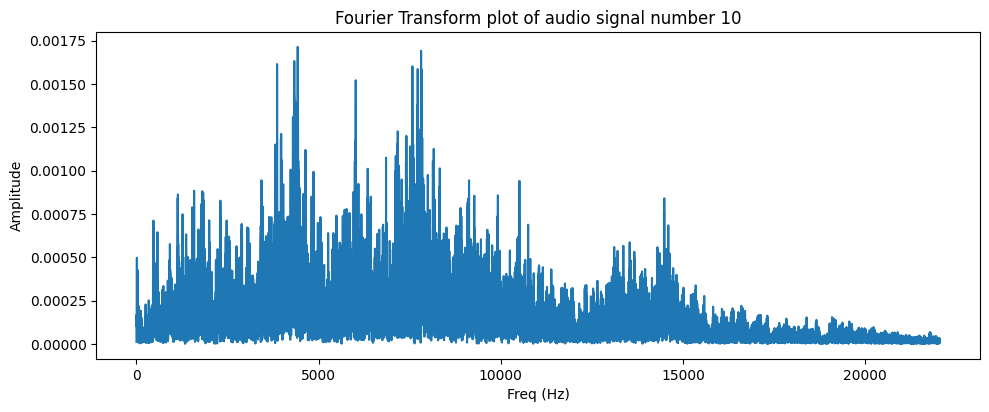

In [6]:
visualizer.create_frequency_plot(audio_signal_index=audio_index)

# Model Fitting
We build and fit the SVM model on the original data

In [5]:
from src.model.svm import SVModel

model = SVModel(C=5, kernel="rbf")
X_train, X_test, Y_train, Y_test = SVModel.train_test_split(X=X_mfcc, Y=Y)
model.train_model(X_train, Y_train)

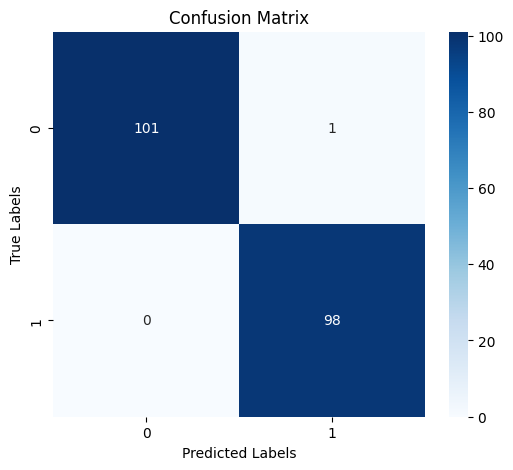

In [6]:
from src.visualization.model_fit_visulization import ModelFitVisualizer
fit_visualizer = ModelFitVisualizer()

y_pred = model.classify(X_test)
fit_visualizer.create_confusion_matrix(y_test=model.fit_transform(Y_test), y_pred=y_pred)

In [7]:
file_name = "../data/additional_files/00000995-100507[002].edf"
rml_file_name = "../data/additional_files/00000995-100507.rml"

In [8]:
from src.io.edf_loader import PSGLoader
psg_loader = PSGLoader(channel="Mic")
psg_loader.load_audio_file(file_name, rml_file_name)

edf_data = psg_loader.get_data()

X_mic = np.array(edf_data[psg_loader.AUDIO_COL_NAME])
X_mic_sample_rate = edf_data[psg_loader.SAMPLE_RATE_COL_NAME]
Y_mic = edf_data[psg_loader.LABEL_COL_NAME]

preprocessor = AudioPreprocessor(X_mic, X_mic_sample_rate)
X_mic_mfcc = preprocessor.extract_mffc_features()

Test the SVD model on the PSG data

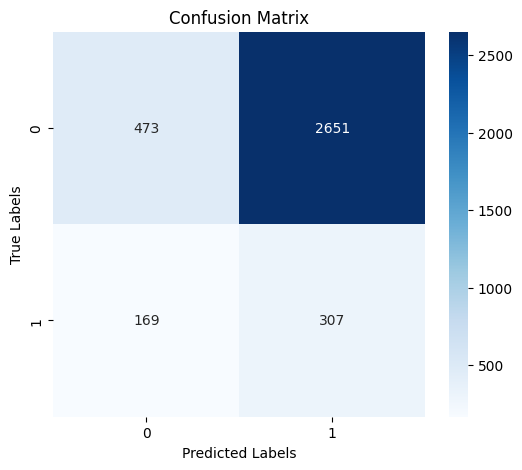

In [9]:
y_pred = model.classify(X_mic_mfcc)
fit_visualizer.create_confusion_matrix(y_test=Y_mic, y_pred = y_pred)

The results are very bad. This is not surprising, when listening to the differnt samples. The original SVM was trained on all kinds of sounds like door openining, dogs barking and other very differnt sounds, against dedicated snoring sounds. The PSG data contains only sleeping and snoring data

Training a SVM on the PSG data

In [10]:
from src.model.svm import SVModel
model_2 = SVModel(C=5, kernel="rbf")
model_2.train_model(X_mic_mfcc, Y_mic)

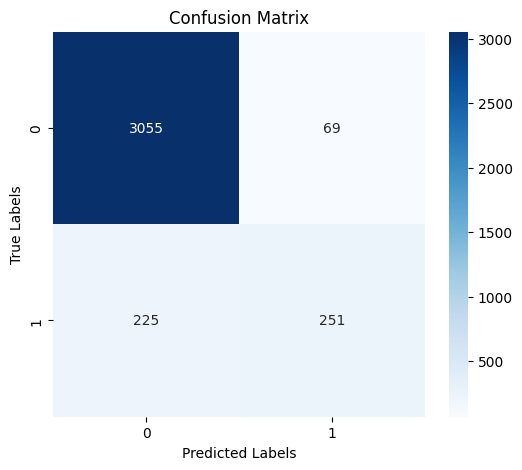

In [11]:
Y_mic_pred = model_2.classify(X_mic_mfcc)
fit_visualizer.create_confusion_matrix(Y_mic, Y_mic_pred)

It seems that it is not easy to separate the snoring sounds from the breathing sounds. Only a little above half of all the snoring sounds were correctly identified. We can take a quick look at sounds to hear if the dataset is labeled accurately 

In [24]:
from IPython.display import display, Audio

# Function to play audio from DataFrame
def play_audio_from_df(df, index):
    audio_data = df.loc[index, data_loader.AUDIO_COL_NAME]
    sample_rate = df.loc[index, data_loader.SAMPLE_RATE_COL_NAME]
    label = df.loc[index,data_loader.LABEL_COL_NAME]
    
    print(f"Playing label: {label}")
    display(Audio(data=audio_data, rate=sample_rate))

snoring_indices = np.where(Y_mic == 1)[0]
Y_mic_pred = model_2.classify(X_mic_mfcc)
missed_snoring = np.where((Y_mic == 1) & (Y_mic_pred == 0))[0]
false_snoring = np.where((Y_mic == 0) & (Y_mic_pred == 1))[0]


In [31]:
# Play the first audio clip
play_audio_from_df(edf_data, missed_snoring[8])

Playing label: 1.0


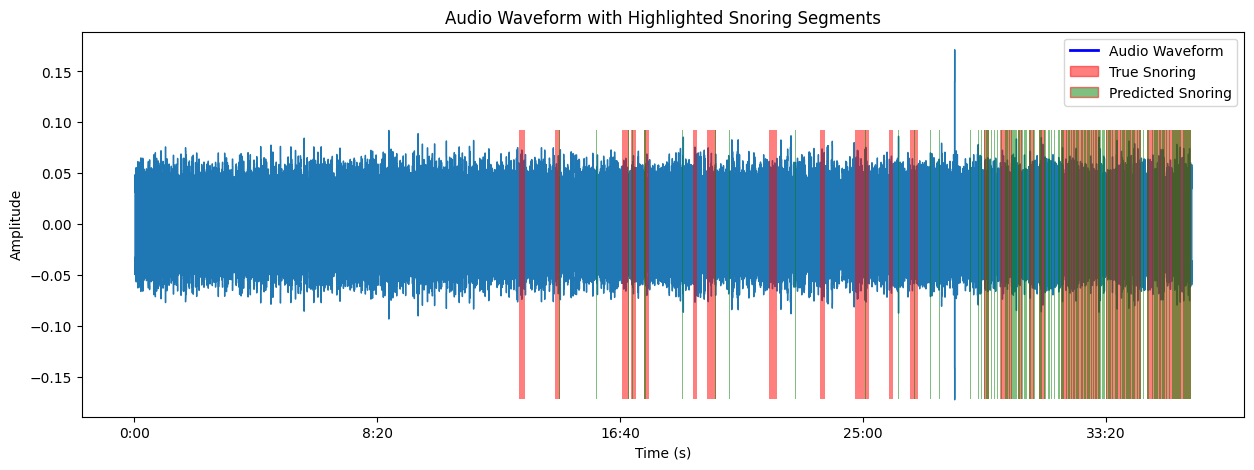

In [16]:
from src.visualization.model_fit_visulization import ModelFitVisualizer
start_index = 2000
visualization_length = 1000
end_index = start_index + visualization_length

model_visualizer = ModelFitVisualizer()
model_visualizer.plot_audio_with_labels(X_mic[start_index : end_index],X_mic_sample_rate[start_index : end_index], y_pred=Y_mic_pred[start_index : end_index], y_true=Y_mic[start_index : end_index])

